In [8]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx
import graph_tool.all as gt
from motif_counts import *
from tqdm.auto import tqdm
from collections import defaultdict
from collections import defaultdict
from tqdm import tqdm
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import networkx as nx
#from tqdm.notebook import tqdm

In [10]:
keys_to_remove = [1, 2,3]

for k in keys_to_remove:
    motifs.pop(k, None) 

#
# 1) Grab the sorted list of remaining old keys
old_keys = sorted(motifs.keys())

# 2) Build a mapping old→new
old_to_new = { old: new for new, old in enumerate(old_keys, start=1) }

# 3) Re-index motifs, exp_counts, obs_counts
motifs      = { old_to_new[old]: motifs[old]      for old in old_keys }

In [2]:
df = pd.read_feather('motifcounts_triplets.feather')

In [11]:
dfg = pd.read_feather('mcns_fw_edge_comp.feather')
# 1) build a unique list of all node labels
labels = np.unique(np.concatenate([dfg['pre'].values, dfg['post'].values]))

# 2) create the graph and a string vertex‐property to store the label
g = gt.Graph(directed=True)
v_label = g.new_vp("string")
g.vp["label"] = v_label

# 3) add one vertex per label, keep a Python dict to map label→vertex
label2v = {}
for L in labels:
    v = g.add_vertex()
    label2v[L] = v
    v_label[v] = str(L)

# 4) create a float edge‐property for your weights
e_weight = g.new_ep("float")
g.ep["weight"] = e_weight

# 5) add all edges with their weights
edge_list = [
    (label2v[src], label2v[tgt], float(w))
    for src, tgt, w in dfg[['pre','post','weight_m']].itertuples(index=False)
]
g.add_edge_list(edge_list, eprops=[g.ep["weight"]])
loops = [e for e in g.edges() if e.source() == e.target()]
for e in loops:
    g.remove_edge(e)

In [3]:


# 1) canonical unchanged
def canonical(edges):
    best = None
    for perm in itertools.permutations([0,1,2]):
        mapped = tuple(sorted((perm[u], perm[v]) for u,v in edges))
        if best is None or mapped < best:
            best = mapped
    return best

# 2) load
#df = pd.read_feather('motifcounts_triplets.feather')

# 3) enable a progress bar on pandas apply
tqdm.pandas(desc='Canonicalizing patterns')

# 4) compute canonicals with progress
df['canon'] = df['edges'].progress_apply(
    lambda arr: canonical([tuple(edge) for edge in arr])
)

df['pattern_id'] = pd.factorize(df['canon'])[0]

# 5) get counts per canonical pattern
counts = df.groupby(['pattern_id','canon','paper_id']).size().rename('count').reset_index().sort_values('paper_id')
me2paper_map = {0:3,1:5,2:2,3:1,4:6,5:12,6:11,7:8,8:4,9:10,10:13,11:9,12:7}
df['paper_id'] = df.loc[:,"pattern_id"].apply(lambda x: me2paper_map[x])
print(counts)


Canonicalizing patterns: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168543875/168543875 [23:19<00:00, 120396.97it/s]


    pattern_id                                             canon     count
0            0                                  ((0, 1), (1, 2))  45380426
1            1                          ((0, 1), (0, 2), (1, 0))  23258804
2            2                                  ((0, 1), (2, 1))  28987508
3            3                                  ((0, 1), (0, 2))  30083225
4            4                          ((0, 1), (1, 0), (2, 0))  20460890
5            5          ((0, 1), (0, 2), (1, 0), (1, 2), (2, 0))   2259341
6            6                  ((0, 1), (0, 2), (1, 0), (2, 0))   5812706
7            7                  ((0, 1), (0, 2), (1, 0), (1, 2))   2355272
8            8                          ((0, 1), (0, 2), (1, 2))   5626957
9            9                  ((0, 1), (0, 2), (1, 0), (2, 1))   1568889
10          10  ((0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1))    573680
11          11                  ((0, 1), (0, 2), (1, 2), (2, 1))   1748738
12          12           

In [78]:
counts = df.groupby(['pattern_id','canon','paper_id']).size().rename('count').reset_index().sort_values('paper_id')

((0, 1), (0, 2))
((0, 1), (2, 1))
((0, 1), (1, 2))
((0, 1), (0, 2), (1, 2))
((0, 1), (0, 2), (1, 0))
((0, 1), (1, 0), (2, 0))
((0, 1), (1, 2), (2, 0))
((0, 1), (0, 2), (1, 0), (1, 2))
((0, 1), (0, 2), (1, 2), (2, 1))
((0, 1), (0, 2), (1, 0), (2, 1))
((0, 1), (0, 2), (1, 0), (2, 0))
((0, 1), (0, 2), (1, 0), (1, 2), (2, 0))
((0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1))


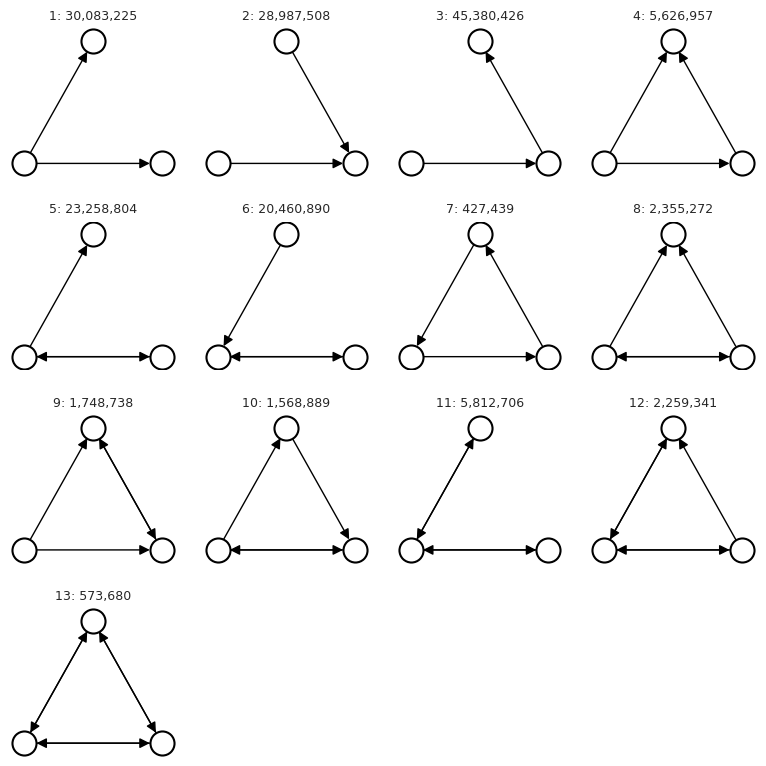

In [94]:
import matplotlib.pyplot as plt
import networkx as nx


counts_lookup = counts.set_index('pattern_id')[['paper_id','count']]

# fixed 3‐node layout
pos = {
    0: (0.0, 0.0),
    1: (1.0, 0.0),
    2: (0.5, 0.866)
}

def plot_triplet_with_counts(ax, key, counts):
    
    edge = counts.loc[counts['paper_id']==key,'canon'].item()
    oc = counts.loc[counts['paper_id']==key,'count'].item()
    G = nx.DiGraph()
    G.add_nodes_from([0,1,2])
    G.add_edges_from(edge)
    nx.draw_networkx_nodes(
    G, pos,ax=ax, 
    node_size=300,
    node_color='white',
    edgecolors='black'
    )
    
    for u, v in edge:
        if (v, u) in edge_list:
            rad   = 0.3 if u < v else -0.3
            style = f'arc3,rad={rad}'
        else:
            style = 'arc3,rad=0'

        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            ax=ax,
            arrowstyle='-|>',
            arrowsize=15,
            connectionstyle=style
        )



    ax.set_axis_off()
    ax.set_title(f"{key}: {oc:,}", fontsize=9)


# now make the 4×4 grid
cols = 4
rows = (len(motifs) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.flatten()
for ax, key in zip(axes, list(counts['paper_id'])):
    plot_triplet_with_counts(ax, key, counts)




for ax in axes[len(motifs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [12]:
import networkx as nx

nxg = nx.DiGraph()

# 2) Add all nodes (we’ll keep the original integer IDs)
for v in g.vertices():
    vid = int(v)        # graph-tool uses Vertex objects, cast to int
    nxg.add_node(vid)
    
# 3) Add all directed edges
for e in g.edges():
    src = int(e.source())
    tgt = int(e.target())
    nxg.add_edge(src, tgt)

# 4) Now call your motif routines on the NX graph
triplet_pr, pair_pr = compute_three_neuron_motif_probabilities(nxg)
exp_counts     = compute_expected_three_neuron_motifs(nxg, triplet_pr)

1
1
0
2
0
1
0
1
2
1
1
2
0
1
1
2
1
0
1
1
0
2
0
0
1
2
1
0
1
2
1
1
2
2
0
1
2
0
1
0
1
2
2
0
1


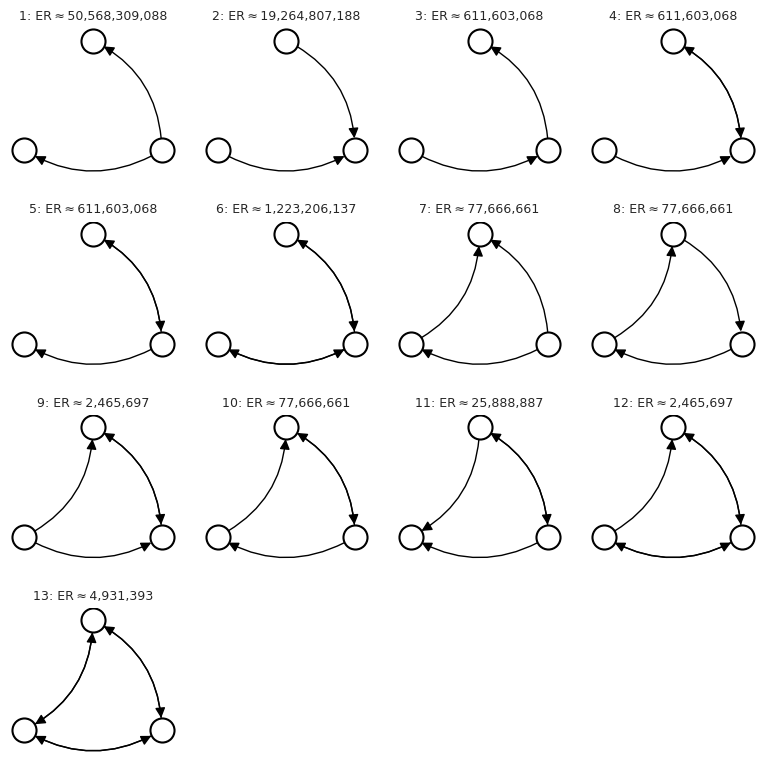

In [89]:
pos = {
    0: (0.0, 0.0),
    1: (1.0, 0.0),
    2: (0.5, 0.866)
}

def plot_triplet_with_exp(triplet, motif_id, exp_counts, ax):
    # build a tiny DiGraph
    G = nx.DiGraph()
    G.add_nodes_from([0,1,2])
    edges = triplet.get_edges()
    G.add_edges_from(edges)
    
    # draw nodes
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=300,
        node_color='white',
        edgecolors='black'
    )
    
    # draw edges (curved if reciprocal)
    for u, v in edges:
        if (v, u) in edges:
            rad = 0.3 if u < v else -0.3
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u,v)], ax=ax,
                arrowstyle='-|>',
                arrowsize=15,
                connectionstyle=f'arc3,rad={rad}'
            )

    ax.set_axis_off()
    # title with motif ID and formatted expected count
    ec = exp_counts.get(motif_id, float('nan'))
    ax.set_title(f"{motif_id}: ER ≈ {ec:,.0f}", fontsize=9)

# layout grid
cols = 4
rows = (len(motifs) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.flatten()

# plot each motif
for ax, (mid, tri) in zip(axes, motifs.items()):
    plot_triplet_with_exp(tri, mid, exp_counts, ax)

# hide any extra axes
for ax in axes[len(motifs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()
